In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.tabletop_model
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff

from genjax.generative_functions.distributions import ExactDensity
import bayes3d as b
from dataclasses import dataclass
console = genjax.pretty(show_locals=False)
import matplotlib

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [3]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.0
)

b.setup_renderer(intrinsics)

cube = b.mesh.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.02]))
cube2 = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.02, 0.1]))
table = b.mesh.make_cuboid_mesh(jnp.array([1.0, 1.0, 0.001]))
b.RENDERER.add_mesh(cube)
b.RENDERER.add_mesh(cube2)
b.RENDERER.add_mesh(table)

[E rasterize_gl.cpp:122] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.3]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
all_box_dims = b.RENDERER.model_box_dims
key = jax.random.PRNGKey(13)

In [5]:
importance_jit = jax.jit(b.tabletop_model.tabletop_model.importance)

57259.855
[-0.10961409  0.16837026  1.4807453 ]


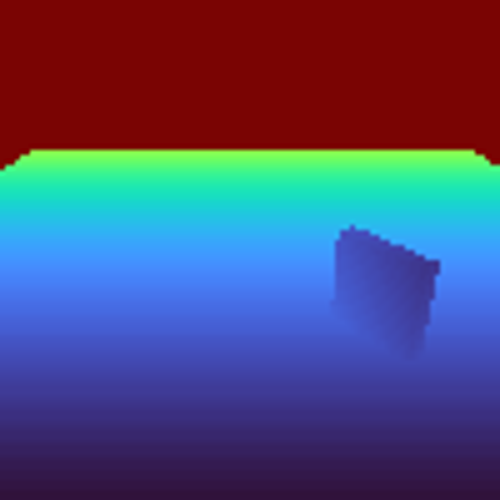

In [14]:
N = 2
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(2),
    "id_1": jnp.int32(1),
    "face_parent_1": jnp.int32(2),
    "face_child_1": jnp.int32(3),
    # "contact_params_1": jnp.array([0.0, 0.1, 0.9]),
    "variance": 0.00001,
    "outlier_prob": 0.0001,
}), (jnp.arange(N), jnp.arange(3), root_poses[:N], all_box_dims, 10000.0,))
b.clear()
print(trace.get_score())
b.tabletop_model.viz_trace_meshcat(trace)
observed_image = trace.get_retval()[0]
print(trace["contact_params_0"])
b.scale_image(b.get_depth_image(observed_image[...,2]),5.0)

In [7]:
enumerator = lambda trace, key, address, c: trace.update(
    key,
    genjax.choice_map({
        address: c, 
    }),
    jtu.tree_map(lambda v: Diff(v, UnknownChange), trace.args),
)[1][2]
enumerator_vmap_jit = jax.jit(jax.vmap(
    enumerator, in_axes=(None, None, None, 0)), static_argnames=("address",))

In [15]:
N = 3
choices = trace.get_choices()
choices["parent_2"] = 0
choices["id_2"] = jnp.int32(0)
choices["face_parent_2"] = jnp.int32(2)
choices["face_child_2"] = jnp.int32(3)

In [ ]:
key, (_,trace) = importance_jit(key, choices, (jnp.arange(N), jnp.arange(3), root_poses[:N], all_box_dims, 1.0,))
b.tabletop_model.viz_trace_meshcat(trace)

In [ ]:
contact_param_deltas = b.enumerations.make_translation_grid_enumeration_3d(-0.4, -0.4, 0.0, 0.4, 0.4, 0.0, 70, 70, 1)
traces = enumerator_vmap_jit(trace, key, "contact_params_2", contact_param_deltas)
scores = traces.get_score()
plt.plot(b.utils.normalize_log_scores(scores));

sampled_index = jax.random.categorical(key, scores)
print(sampled_index)
keys = jax.random.split(key, 1)
key = keys[0]
print(traces.slice(sampled_index).get_score())
b.tabletop_model.viz_trace_meshcat(traces.slice(sampled_index))

poses = b.tabletop_model.get_poses(traces)

sampled_indices = jax.random.categorical(key, scores, shape=(500,))

poses_subset = poses[sampled_indices]

img = b.render_point_cloud(poses_subset[:,2,:3,3], intrinsics,pixel_smudge=0.5)
overlay = b.get_depth_image(img[:,:,2], cmap=matplotlib.colormaps['Greys'])

b.scale_image(b.overlay_image(b.get_depth_image(trace["image"][...,2]), overlay, 0.5), 5.0)